In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_data():
    """Load and prepare all necessary data"""
    lap_times = pd.read_csv('lap_times.csv')
    pit_stops = pd.read_csv('pit_stops.csv')
    qualifying = pd.read_csv('qualifying.csv')
    races = pd.read_csv('races.csv')
    results = pd.read_csv('results.csv')
    circuits = pd.read_csv('circuits.csv')
    
    # Merge lap times with races and circuits
    lap_times = lap_times.merge(
        races[['raceId', 'year', 'round', 'circuitId']], 
        on='raceId'
    ).merge(
        circuits[['circuitId', 'name']], 
        on='circuitId'
    )
    
    # Merge pit stops with races and circuits
    pit_stops = pit_stops.merge(
        races[['raceId', 'year', 'round', 'circuitId']], 
        on='raceId'
    ).merge(
        circuits[['circuitId', 'name']], 
        on='circuitId'
    )
    
    # Merge qualifying with races and circuits
    qualifying = qualifying.merge(
        races[['raceId', 'year', 'round', 'circuitId']], 
        on='raceId'
    ).merge(
        circuits[['circuitId', 'name']], 
        on='circuitId'
    )
    
    # Merge results with races and circuits
    results = results.merge(
        races[['raceId', 'year', 'round', 'circuitId']], 
        on='raceId'
    ).merge(
        circuits[['circuitId', 'name']], 
        on='circuitId'
    )
    
    return lap_times, pit_stops, qualifying, results, circuits






In [6]:
def analyze_pit_stop_timing(lap_times, pit_stops):
    """Analyze optimal pit stop timing"""
    # Calculate lap time statistics before and after pit stops
    pit_stop_laps = pit_stops['lap'].unique()
    
    # Get lap times around pit stops
    pit_stop_windows = []
    for lap in pit_stop_laps:
        window = lap_times[
            (lap_times['lap'] >= lap - 5) & 
            (lap_times['lap'] <= lap + 5)
        ]
        pit_stop_windows.append(window)
    
    pit_stop_analysis = pd.concat(pit_stop_windows)
    
    # Calculate average lap times before and after pit stops
    pit_stop_analysis['relative_lap'] = pit_stop_analysis.groupby(['raceId', 'driverId', 'lap'])['lap'].transform(
        lambda x: x - x.iloc[0]
    )
    
    return pit_stop_analysis

In [7]:
def analyze_tire_degradation(lap_times, pit_stops):
    """Analyze tire degradation patterns"""
    # Calculate lap time progression for each stint
    stint_data = []
    for _, race in lap_times.groupby('raceId'):
        for _, driver in race.groupby('driverId'):
            # Get pit stops for this driver in this race
            driver_pits = pit_stops[
                (pit_stops['raceId'] == race['raceId'].iloc[0]) & 
                (pit_stops['driverId'] == driver['driverId'].iloc[0])
            ]
            
            # Calculate stint lap times
            for i in range(len(driver_pits) + 1):
                start_lap = 1 if i == 0 else driver_pits.iloc[i-1]['lap']
                end_lap = driver_pits.iloc[i]['lap'] if i < len(driver_pits) else race['lap'].max()
                
                stint = driver[
                    (driver['lap'] >= start_lap) & 
                    (driver['lap'] <= end_lap)
                ]
                
                if not stint.empty:
                    stint['stint_number'] = i
                    stint_data.append(stint)
    
    stint_analysis = pd.concat(stint_data)
    
    # Calculate degradation rate (lap time increase per lap)
    stint_analysis['relative_lap'] = stint_analysis.groupby(['raceId', 'driverId', 'stint_number'])['lap'].transform(
        lambda x: x - x.iloc[0]
    )
    
    return stint_analysis

In [8]:
def analyze_pace_correlation(qualifying, results):
    """Analyze race pace vs qualifying pace correlation"""
    # Calculate qualifying pace (best Q3 time)
    qualifying_pace = qualifying.groupby(['raceId', 'driverId'])['q3'].min().reset_index()
    
    # Calculate race pace (average lap time)
    race_pace = results.groupby(['raceId', 'driverId'])['fastestLapTime'].mean().reset_index()
    
    # Merge qualifying and race pace
    pace_comparison = qualifying_pace.merge(
        race_pace, 
        on=['raceId', 'driverId']
    )
    
    # Convert lap times to seconds for comparison
    pace_comparison['q3_seconds'] = pace_comparison['q3'].apply(lambda x: 
        sum(float(t) * 60**i for i, t in enumerate(reversed(x.split(':'))))
    )
    pace_comparison['race_seconds'] = pace_comparison['fastestLapTime'].apply(lambda x: 
        sum(float(t) * 60**i for i, t in enumerate(reversed(x.split(':'))))
    )
    
    return pace_comparison

In [9]:
def analyze_grid_impact(results):
    """Analyze impact of starting position on race outcome"""
    # Calculate position gained/lost
    results['positions_gained'] = results['grid'] - results['positionOrder']
    
    # Calculate points scored
    results['points_scored'] = results['points']
    
    # Group by starting position and calculate average performance
    grid_analysis = results.groupby('grid').agg({
        'positions_gained': 'mean',
        'points_scored': 'mean',
        'positionOrder': 'mean'
    }).reset_index()
    
    return grid_analysis

In [10]:
def plot_pit_stop_analysis(pit_stop_analysis):
    """Plot pit stop timing analysis"""
    plt.figure(figsize=(12, 6))
    
    # Plot average lap times around pit stops
    sns.lineplot(
        data=pit_stop_analysis,
        x='relative_lap',
        y='milliseconds',
        ci=95
    )
    
    plt.title('Lap Time Evolution Around Pit Stops')
    plt.xlabel('Laps Relative to Pit Stop')
    plt.ylabel('Lap Time (milliseconds)')
    plt.tight_layout()
    plt.savefig('pit_stop_timing.png')

In [11]:
def plot_tire_degradation(stint_analysis):
    """Plot tire degradation patterns"""
    plt.figure(figsize=(12, 6))
    
    # Plot lap time progression for each stint
    sns.lineplot(
        data=stint_analysis,
        x='relative_lap',
        y='milliseconds',
        hue='stint_number',
        ci=95
    )
    
    plt.title('Tire Degradation Patterns')
    plt.xlabel('Laps in Stint')
    plt.ylabel('Lap Time (milliseconds)')
    plt.legend(title='Stint Number')
    plt.tight_layout()
    plt.savefig('tire_degradation.png')

In [12]:
def plot_pace_correlation(pace_comparison):
    """Plot race pace vs qualifying pace correlation"""
    plt.figure(figsize=(10, 10))
    
    # Create scatter plot
    sns.scatterplot(
        data=pace_comparison,
        x='q3_seconds',
        y='race_seconds',
        alpha=0.5
    )
    
    # Add diagonal line
    min_time = min(pace_comparison['q3_seconds'].min(), pace_comparison['race_seconds'].min())
    max_time = max(pace_comparison['q3_seconds'].max(), pace_comparison['race_seconds'].max())
    plt.plot([min_time, max_time], [min_time, max_time], 'r--', alpha=0.5)
    
    plt.title('Race Pace vs Qualifying Pace')
    plt.xlabel('Qualifying Pace (seconds)')
    plt.ylabel('Race Pace (seconds)')
    plt.tight_layout()
    plt.savefig('pace_correlation.png')


In [13]:
def plot_grid_impact(grid_analysis):
    """Plot impact of starting position"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot positions gained
    sns.lineplot(
        data=grid_analysis,
        x='grid',
        y='positions_gained',
        ax=ax1
    )
    ax1.set_title('Average Positions Gained by Starting Position')
    ax1.set_xlabel('Starting Position')
    ax1.set_ylabel('Positions Gained')
    
    # Plot points scored
    sns.lineplot(
        data=grid_analysis,
        x='grid',
        y='points_scored',
        ax=ax2
    )
    ax2.set_title('Average Points Scored by Starting Position')
    ax2.set_xlabel('Starting Position')
    ax2.set_ylabel('Points Scored')
    
    plt.tight_layout()
    plt.savefig('grid_impact.png')


Analyzing pit stop timing...

Analyzing tire degradation patterns...

Analyzing race vs qualifying pace correlation...


TypeError: agg function failed [how->mean,dtype->object]

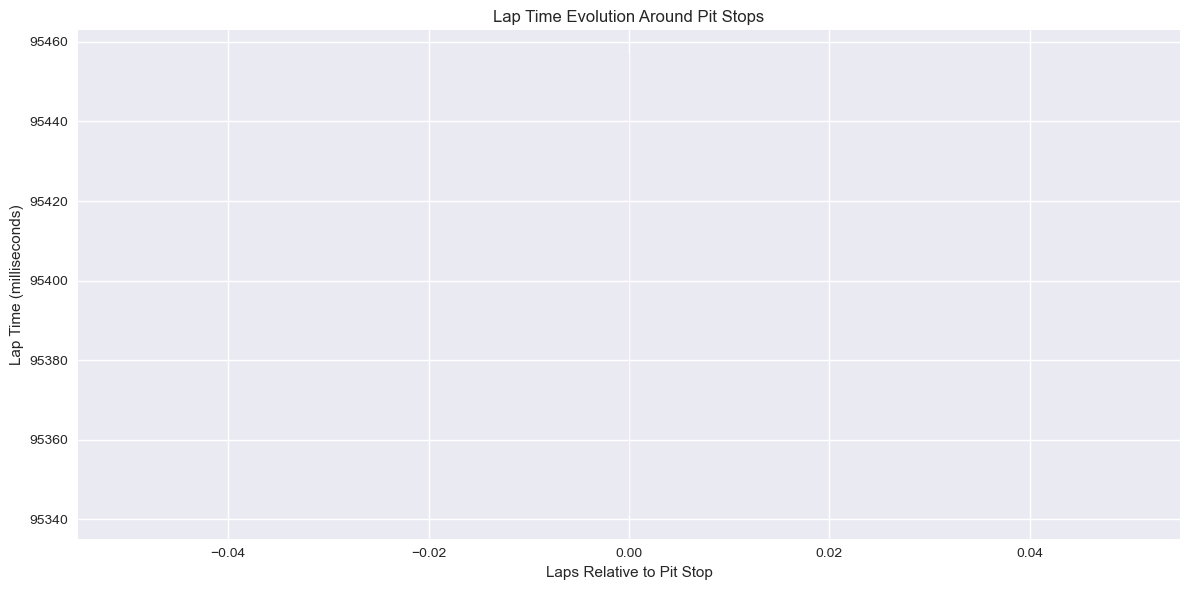

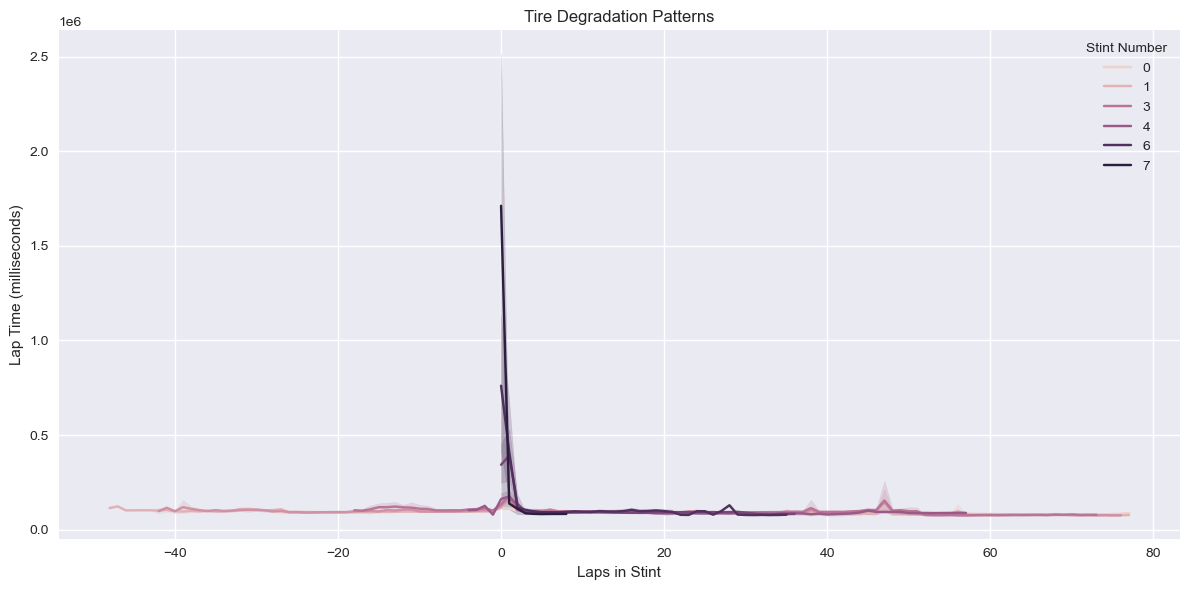

In [14]:
def main():
    # Load data
    lap_times, pit_stops, qualifying, results, circuits = load_data()
    
    # 1. Pit Stop Timing Analysis
    print("\nAnalyzing pit stop timing...")
    pit_stop_analysis = analyze_pit_stop_timing(lap_times, pit_stops)
    plot_pit_stop_analysis(pit_stop_analysis)
    
    # 2. Tire Degradation Analysis
    print("\nAnalyzing tire degradation patterns...")
    stint_analysis = analyze_tire_degradation(lap_times, pit_stops)
    plot_tire_degradation(stint_analysis)
    
    # 3. Pace Correlation Analysis
    print("\nAnalyzing race vs qualifying pace correlation...")
    pace_comparison = analyze_pace_correlation(qualifying, results)
    correlation = pace_comparison['q3_seconds'].corr(pace_comparison['race_seconds'])
    print(f"\nCorrelation between qualifying and race pace: {correlation:.3f}")
    plot_pace_correlation(pace_comparison)
    
    # 4. Grid Position Impact Analysis
    print("\nAnalyzing impact of starting position...")
    grid_analysis = analyze_grid_impact(results)
    print("\nAverage positions gained by starting position:")
    print(grid_analysis[['grid', 'positions_gained', 'points_scored']].head(10))
    plot_grid_impact(grid_analysis)

if __name__ == "__main__":
    main() 